In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics, preprocessing
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from keras.layers import Dense, Input
from collections import Counter
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers import Dropout

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_err_data.csv')
train_problem = pd.read_csv('/content/drive/MyDrive/데이콘/data/train_problem_data.csv')
test_err = pd.read_csv('/content/drive/MyDrive/데이콘/data/test_err_data.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/데이콘/data/sample_submission.csv')

In [4]:
problem = np.zeros(15000)
problem[train_problem.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [5]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))

for person_idx, err in tqdm(id_error):
  error[person_idx-10000,err-1]+=1
error.shape

100%|██████████| 16554663/16554663 [00:42<00:00, 387788.57it/s]


(15000, 42)

In [6]:
problem_df = pd.DataFrame(problem)
problem_df.rename({0:'problem'},axis=1,inplace=True)
problem_df['problem'].value_counts()

0.0    10000
1.0     5000
Name: problem, dtype: int64

In [80]:
train_x = error
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 42)
(15000,)


In [81]:
smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_sample(train_x,train_y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (20000, 42) (20000,)
SMOTE 적용 후 레이블 값 분포:
 1.0    10000
0.0    10000
dtype: int64


In [9]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [87]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [00:42<00:00, 387119.05it/s]

(14999, 42)


In [ ]:
y = y_train_over
test = test_x

In [ ]:
def fallback_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except:
        return 0.5

def auc(y_true, y_pred):
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [ ]:
NFOLDS = 5
RANDOM_STATE = 42

In [ ]:
oof_preds = np.zeros((len(x_train_over)))
test_preds = np.zeros((len(y_train_over)))

In [ ]:
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
models     = []
recalls    = []
precisions = []
auc_scores   = []
accuracies   = []
f1_scores = []

threshold = 0.5

for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    print("Current Fold: {}".format(fold_))
    trn_x, trn_y = x_train_over[trn_, :], y[trn_]
    val_x, val_y = x_train_over[val_, :], y[val_]

    inp = Input(shape=(trn_x.shape[1],))
    x = Dense(2000, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1000, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(500, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)
    clf = Model(inputs=inp, outputs=out)
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])

    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)

    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)

    clf.fit(trn_x, trn_y, validation_data=(val_x, val_y), callbacks=[es, rlr], epochs=100, batch_size=1024)
    
    val_prob = clf.predict(val_x)
    valid_preds = np.where(val_prob > threshold, 1, 0)
    # test_fold_preds = clf.predict(x_train_over)
    
    print("AUC = {}".format(metrics.roc_auc_score(val_y, valid_preds)))
    oof_preds[val_] = valid_preds.ravel()


     # cal scores
    recall    = recall_score(val_y, valid_preds)
    precision = precision_score(val_y, valid_preds)
    auc_score = roc_auc_score(val_y, val_prob)
    accuracy  = accuracy_score(val_y,valid_preds)
    f1__score = f1_score(val_y,valid_preds)

    # append scores
    models.append(clf)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)
    f1_scores.append(f1__score)

 
    K.clear_session()
    gc.collect()

Current Fold: 0
Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.7752 - auc: 0.5910 - val_loss: 1.0958 - val_auc: 0.5424
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.6702 - auc: 0.6657 - val_loss: 0.8284 - val_auc: 0.6170
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6734 - auc: 0.6671 - val_loss: 0.7331 - val_auc: 0.6213
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6533 - auc: 0.6892 - val_loss: 0.6855 - val_auc: 0.6325
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6398 - auc: 0.6998 - val_loss: 0.6816 - val_auc: 0.6359
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6413 - auc: 0.7028 - val_loss: 0.6674 - val_auc: 0.6426
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6228 - auc: 0.7261 - val_loss: 0.6578 - val_auc: 0.6497
Epoch 8/100
16/16 [==============================] - 0s 12ms

In [ ]:
print(np.mean(auc_scores))
print(np.mean(accuracies))
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(f1_scores))

0.8042769750000002
0.726
0.7493389740877843
0.7085
0.7237607639815791


In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

In [90]:
def build_model():
    INPUT = Input(shape=(42))
    emb = Dense(80, activation='relu')(INPUT)
    dense = Dense(40, activation='relu')(emb)
    OUTPUT = Dense(1, activation='sigmoid')(dense)
    model = Model(INPUT, OUTPUT)
    return model

In [91]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

1


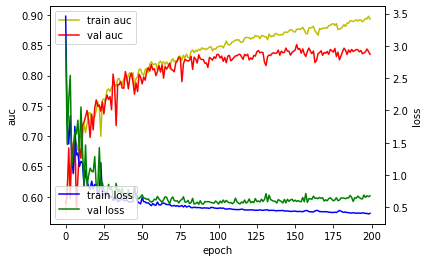

2


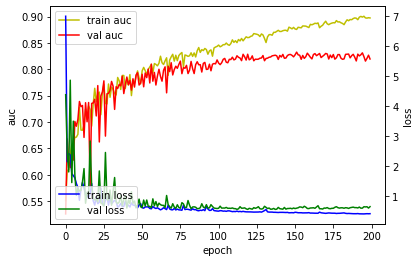

3


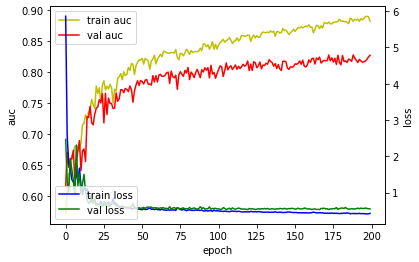

4


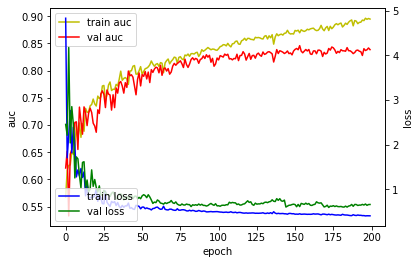

5


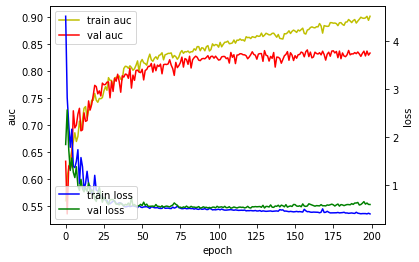

6


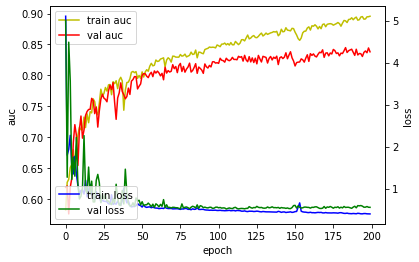

7


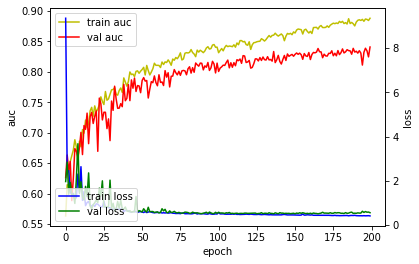

8


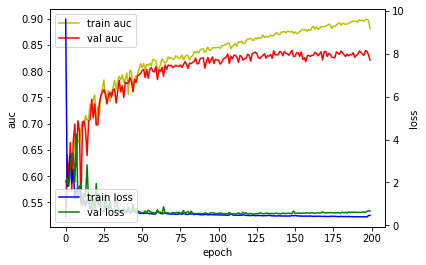

9


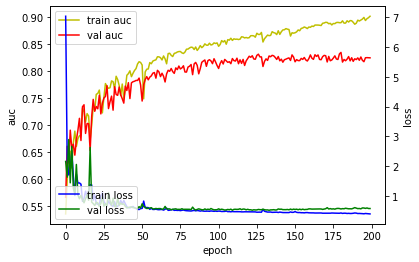

10


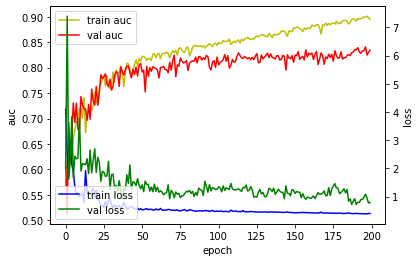

In [92]:
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
accuracies   = []
f1_scores = []

threshold = 0.5
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
fold_var = 1
save_dir = './models/'
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(x_train_over):
    print(fold_var)
    # split train, validation set
    X = x_train_over[train_idx]
    y = y_train_over[train_idx]
    valid_x = x_train_over[val_idx]
    valid_y = y_train_over[val_idx]
    
    #run traning
    model = build_model()
    # adam 0.79(X)  / rmsprop 
    # compile model
    model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.002),
              metrics = [keras.metrics.AUC()])
    
    checkpoint_path = save_dir + get_model_name(fold_var)
    checkpoint = ModelCheckpoint(checkpoint_path,  
                                 save_best_only=True, 
                                 monitor='val_auc',
                                 mode='max',
                                 verbose=0)
    
    # print(model.summary())
    hist = model.fit(X, y, epochs=200, validation_data=(valid_x, valid_y), batch_size=256, verbose=0,
              callbacks=[checkpoint])
    
    # load best weights f'./models/model_{str(fold_var)}.h5'
    model.load_weights(checkpoint_path)
    
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['auc'], 'y', label='train auc')
    loss_ax.plot(hist.history['val_auc'], 'r', label='val auc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('auc')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['loss'], 'b', label='train loss')
    acc_ax.plot(hist.history['val_loss'], 'g', label='val loss')
    acc_ax.set_ylabel('loss')
    acc_ax.legend(loc='lower left')

    plt.show()
    
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # scores = model.evaluate(valid_x, valid_y, verbose=0)
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)
    accuracy  = accuracy_score(valid_y,valid_pred)
    f1__score = f1_score(valid_y,valid_pred)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)
    f1_scores.append(f1__score)

    K.clear_session()
    fold_var += 1
    print('==========================================================')

In [93]:
print(np.mean(auc_scores))
print(np.mean(accuracies))
print(np.mean(precision))
print(np.mean(recall))
print(np.mean(f1_scores))

0.8396809313173872
0.7456999999999999
0.9834205933682374
0.6135002721829069
0.7388768515180285


In [94]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)
pred_ensemble

InvalidArgumentError: ignored

In [63]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [46]:
train = pd.DataFrame(x_train_over)
train['problem'] = y_train_over
train.shape

(20000, 43)

In [55]:
train_x, valid_x,train_y,valid_y = train_test_split(x_train_over,y_train_over,test_size=0.2)

In [60]:
train = pd.DataFrame(train_x)
train['problem'] = train_y
train.shape

(16000, 43)

In [56]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(16000, 42)
(16000,)
(4000, 42)
(4000,)


In [72]:
train_x = pd.DataFrame(train_x)
valid_x = pd.DataFrame(valid_x)
print(train_x.shape)
print(valid_x.shape)

(16000, 42)
(4000, 42)


In [71]:
train_y = pd.DataFrame(train_y)
print(train_y.shape)
valid_y = pd.DataFrame(valid_y)
print(valid_y.shape)

(16000, 1)
(4000, 1)


In [75]:
def ann_slp():
    print("===========Data Summary===========")
    print("Training Data :", train_x.shape)
    print("Testing Data :", test_x.shape)

    X = tf.placeholder(tf.float32, [None,42])
    Y = tf.placeholder(tf.float32, [None, 1])

    W = tf.Variable(tf.random_normal([42,1], seed=0), name='weight')
    b = tf.Variable(tf.random_normal([1], seed=0), name='bias')

    logits = tf.matmul(X,W) + b
    hypothesis = tf.nn.sigmoid(logits)
    
    cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
    cost = tf.reduce_mean(cost_i)

    train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

    prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

    print("\n============Processing============")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(10001):
            sess.run(train, feed_dict={X: train_x, Y: train_y})
            if step % 1000 == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
                print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))

        train_acc = sess.run(accuracy, feed_dict={X: train_x, Y: train_y})
        test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: valid_x, Y: valid_y})
        
        print("\n============Results============")
        print("Model Prediction =", train_acc)
        print("Test Prediction =", test_acc)
        
        return train_acc,test_acc
    
ann_slp_train_acc, ann_slp_test_acc = ann_slp()

===========Data Summary===========
Training Data : (16000, 42)
Testing Data : (14999, 42)

============Processing============
Step:     0	Loss: 236.559	Acc: 45.02%
Step:  1000	Loss: 5.534	Acc: 61.02%
Step:  2000	Loss: 6.068	Acc: 51.63%
Step:  3000	Loss: 7.050	Acc: 61.69%
Step:  4000	Loss: 5.317	Acc: 61.37%
Step:  5000	Loss: 4.291	Acc: 62.41%
Step:  6000	Loss: 6.045	Acc: 52.36%
Step:  7000	Loss: 16.752	Acc: 53.71%
Step:  8000	Loss: 6.340	Acc: 61.98%
Step:  9000	Loss: 5.802	Acc: 55.56%
Step: 10000	Loss: 6.386	Acc: 55.79%

============Results============
Model Prediction = 0.557875
Test Prediction = 0.553


In [ ]:
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

In [77]:
X=x_train_over.astype(float)  
Y=y_train_over.astype(np.int32)
print(X.shape)
print(Y.shape)

(20000, 42)
(20000,)


In [79]:
# Modeling
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=42))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])     
model.fit(X,Y,verbose=1,shuffle=True, nb_epoch=3,batch_size=100,validation_split=0.2)


score = model.evaluate(X,Y, batch_size=16)
print("LOSS")
print(score[0])
print("precision")
print(score[1])

Train on 16000 samples, validate on 4000 samples
Epoch 1/3
16000/16000 [==============================] - 1s 37us/sample - loss: 24.1469 - acc: 0.5297 - val_loss: 6.4566 - val_acc: 0.1830
Epoch 2/3
16000/16000 [==============================] - 0s 29us/sample - loss: 10.0956 - acc: 0.5521 - val_loss: 1.4204 - val_acc: 0.1933
Epoch 3/3
16000/16000 [==============================] - 0s 28us/sample - loss: 5.2399 - acc: 0.5701 - val_loss: 1.5130 - val_acc: 0.0780
LOSS
1.0107991053104401
precision
0.52295
